In [26]:
import os
os.environ['DGLBACKEND'] = 'pytorch'

In [27]:
import dgl.function as fn
import torch
import torch.nn as nn
from dgl.data import GINDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling, GNNExplainer

In [28]:
#Load dataset
data = GINDataset('MUTAG', self_loop=True)
dataloader = GraphDataLoader(data, batch_size=64, shuffle=True)

In [29]:
class Model(nn.Module):
  def __init__(self, in_feats, out_feats):
    super(Model, self).__init__()
    self.linear = nn.Linear(in_feats, out_feats)
    self.pool = AvgPooling()
  def forward(self, graph, feat, eweight=None):
    with graph.local_scope():
      feat = self.linear(feat)
      graph.ndata['h'] = feat
      if eweight is None:
        graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
      else:
        graph.edata['w'] = eweight
        graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
      return self.pool(graph, graph.ndata['h'])

In [30]:
feat_size = data[0][0].ndata['attr'].shape[1]
model = Model(feat_size, data.gclasses)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [31]:
for bg, labels in dataloader:
  logits = model(bg, bg.ndata['attr'])
  loss = criterion(logits, labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [32]:
explainer = GNNExplainer(model, num_hops=1)
g, _ = data[0]
features = g.ndata['attr']
feat_mask, edge_mask = explainer.explain_graph(g, features)
feat_mask

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 799.22it/s]


tensor([0.2613, 0.2860, 0.2739, 0.2642, 0.2331, 0.2785, 0.2759])

In [33]:
edge_mask

tensor([0.8379, 0.2341, 0.2255, 0.2162, 0.1584, 0.2176, 0.1802, 0.8436, 0.2124,
        0.2183, 0.8383, 0.1783, 0.8391, 0.2102, 0.2183, 0.1870, 0.2281, 0.1861,
        0.2262, 0.2383, 0.2417, 0.1837, 0.2380, 0.2308, 0.2391, 0.2528, 0.1652,
        0.8472, 0.1965, 0.2349, 0.2507, 0.2019, 0.8361, 0.2266, 0.1428, 0.2096,
        0.2485, 0.8513, 0.2320, 0.2369, 0.2289, 0.2542, 0.2509, 0.2197, 0.2362,
        0.2255, 0.2202, 0.2336, 0.8328, 0.2306, 0.8482, 0.2363, 0.2059, 0.8400,
        0.2326, 0.2544, 0.2362, 0.1394, 0.2354, 0.2262, 0.2538, 0.2365, 0.2477,
        0.2182, 0.2155, 0.1798, 0.1881, 0.2527, 0.2368, 0.2409, 0.2239, 0.2479,
        0.2398, 0.1910, 0.7913, 0.7982, 0.1958])

##Explain the Node

In [34]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.optim as optim
from dgl.data import CoraGraphDataset
from dgl.data import PubmedGraphDataset
from dgl.data import RedditDataset
from dgl.nn import GNNExplainer

In [35]:
# load the cora dataset
data = CoraGraphDataset()
g = data[0]

# set the feature and labels
features = g.ndata['feat']
labels = g.ndata['label']

#set the train, val, test mask
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [36]:
class Model(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(Model, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, graph, feat, eweight=None):
        with graph.local_scope():
            feat = self.linear(feat)
            graph.ndata['h'] = feat
            if eweight is None:
                graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
            else:
                graph.edata['w'] = eweight
                graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
            return graph.ndata['h']

# initialzie the model
model = Model(features.shape[1], data.num_classes)

In [37]:
# sett the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# model training loop
for epoch in range(10):
    model.train()
    logits = model(g, features)
    loss = criterion(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 1.9702006578445435
Epoch 2, Loss: 1.9164707660675049
Epoch 3, Loss: 1.8697270154953003
Epoch 4, Loss: 1.8290958404541016
Epoch 5, Loss: 1.793526530265808
Epoch 6, Loss: 1.7610034942626953
Epoch 7, Loss: 1.72983717918396
Epoch 8, Loss: 1.6991691589355469
Epoch 9, Loss: 1.6686962842941284
Epoch 10, Loss: 1.6384177207946777


In [38]:
explainer = GNNExplainer(model, num_hops=1)

In [39]:
new_center, sg, feat_mask, edge_mask = explainer.explain_node(10, g, features)

  0%|          | 0/100 [00:00<?, ?it/s]

Explain node {node_id}: 100%|██████████| 100/100 [00:00<00:00, 822.51it/s]


In [40]:
new_center

tensor([0])

In [41]:
sg.num_edges()

4

In [42]:
#old IDs of the nodes in the subgraph
sg.ndata[dgl.NID]

tensor([  10,  476, 2545])

In [43]:
sg.edata[dgl.EID] #old IDs of the edges in the subgraph

tensor([   30,    31,  1954, 10223])

In [44]:
feat_mask
#it's more important..

tensor([0.2538, 0.2892, 0.2494,  ..., 0.3141, 0.2812, 0.2605])

In [45]:
edge_mask
#it's not important unless it's 1-hop neighborhood..
#if we have a k-hop... <- we can deal w/ this later on..

tensor([0.7957, 0.8986, 0.1723, 0.1399])

In [46]:
dir(sg)
#using ~explainer, try to access every node in the subgraph...
#to-do-list
#print the node and neighbors for each node.. <- this is right?

['__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_num_edges',
 '_batch_num_nodes',
 '_canonical_etypes',
 '_dsttypes_invmap',
 '_edge_frames',
 '_etype2canonical',
 '_etypes',
 '_etypes_invmap',
 '_find_etypes',
 '_get_e_repr',
 '_get_n_repr',
 '_graph',
 '_idtype_str',
 '_init',
 '_is_unibipartite',
 '_node_frames',
 '_ntypes',
 '_pop_e_repr',
 '_pop_n_repr',
 '_reset_cached_info',
 '_set_e_repr',
 '_set_n_repr',
 '_srctypes_invmap',
 'add_edge',
 'add_edges',
 'add_nodes',
 'add_self_loop',
 'adj',
 'adj_sparse',
 'adjacency_matrix',
 'adjacency_matrix_scipy',
 'all_edges',
 'apply_edges',
 'apply_n

In [47]:
#To-Do-List ->
#Synthetic and real-world
#next step -> using the harvard graph dataset (We need to understand the dataset)
#when they're generating the sub-graph, understand the representation of the dataset
#domain-knowledge on the sub-graph

In [48]:
#To-do-list
#Try to do multiple things
#how to access the subgraph-> Adjacency list
#run for every dataset
#How dataset consists of?.. in other words, in the gnn explainer, experiment(fully understand the process)

In [49]:
#first-order formula

##Visualization

Explain graph: 100%|██████████| 100/100 [00:01<00:00, 78.39it/s]


tensor([ 633, 1862, 2582,    0])
tensor([ 2569,  7565, 10306])


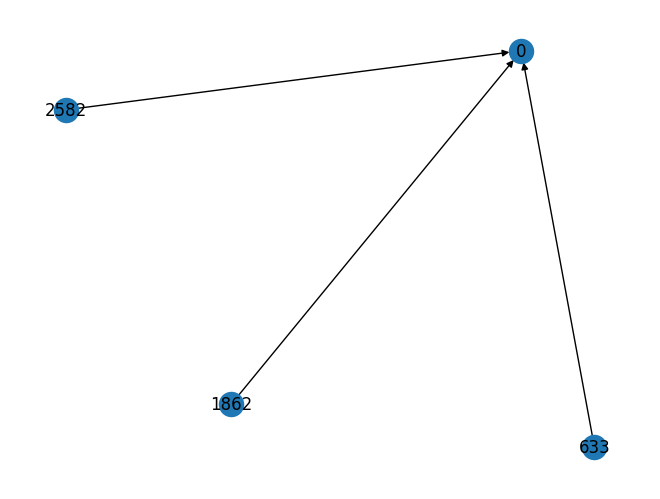

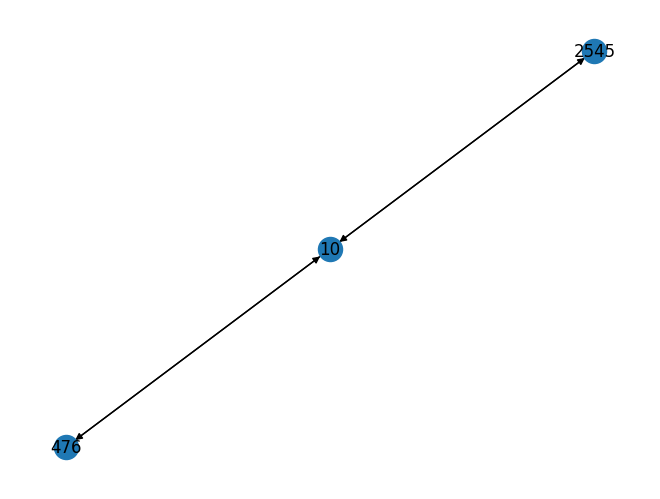

In [50]:
import dgl
import dgl.data
import networkx as nx
import matplotlib.pyplot as plt

# 원본 그래프 생성
g = data[0]

# GNNExplainer를 이용해 edge_mask 계산
explainer = GNNExplainer(model, num_hops=1)
feat_mask, edge_mask = explainer.explain_graph(g, g.ndata['feat'])

# 중요한 에지만 남기고 새로운 그래프 생성
new_g = g.edge_subgraph(torch.nonzero(edge_mask > 0.5).squeeze())

print(new_g.ndata[dgl.NID])
print(new_g.edata[dgl.EID])

# networkx 호환 그래프로 변환 및 시각화
nx_g = new_g.to_networkx()
nx_g = nx.relabel_nodes(nx_g, dict(enumerate(new_g.ndata[dgl.NID].tolist())))
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True)
plt.show()



# 보너스: node explanation 시각화
nx_sg = dgl.to_networkx(sg)
nx_sg = nx.relabel_nodes(nx_sg, dict(enumerate(sg.ndata[dgl.NID].tolist())))
pos = nx.spring_layout(nx_sg)
nx.draw(nx_sg, pos, with_labels=True)
plt.show()
